In [8]:
%load_ext autoreload
%autoreload 2

import helper_functions as hf
from imports import *
import importlib

num_available_cpus = multiprocessing.cpu_count()
print("Number of available CPUs:", num_available_cpus)

torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device =", device)
torch.set_default_tensor_type('torch.cuda.FloatTensor') if torch.cuda.is_available() else print ('cpu')

torch.set_num_threads(num_available_cpus)

print("Number of threads:", torch.get_num_threads())
print("Number of interop threads:", torch.get_num_interop_threads())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of available CPUs: 80
Device = cuda:0
Number of threads: 80
Number of interop threads: 80


In [9]:
from scipy.stats import pearsonr
from sklearn.decomposition import PCA

model = "XYY_X3000_Y80_UL17_clip10_NSRATQUAD_k6_hf120_nbpl4_tb10_addMjj.pt"
bkg_model = "QCDBKG_clip10_NSRATQUAD_k6_hf120_nbpl4_tb10_addMjj.pt"
flow = hf.load_model(name=model)
bkg_flow = hf.load_model(name=bkg_model)
bkg_data, bkg_unnorm, bkg_mass = hf.load_full("QCDBKG",num_batches=2,add_mjj=True)
bkg_mean = np.mean(bkg_unnorm,axis=0)
bkg_std = np.std(bkg_unnorm,axis=0)
sig, sig_unnorm, sig_mass = hf.load_full("XYY_X3000_Y80_UL17",bkg_mean=bkg_mean,bkg_std=bkg_std,add_mjj=True)

In [21]:
sig_losses0 = -flow.eval_log_prob(sig)[0]
bkg_losses0 = -flow.eval_log_prob(bkg_data)[0]

sig_losses_bkg0 = -bkg_flow.eval_log_prob(sig)[0]
bkg_losses_bkg0 = -bkg_flow.eval_log_prob(bkg_data)[0]

corr1, p1 = pearsonr(sig_mass[:,0],sig_losses0)
corr2, p2 = pearsonr(sig_mass[:,0],sig_losses_bkg0)
corr3, p3 = pearsonr(bkg_mass[:,0],bkg_losses0)
corr4, p4 = pearsonr(bkg_mass[:,0],bkg_losses_bkg0)

print("Sig mass - sigtr sig loss correlation: {0}".format(corr1))
print("Sig mass - bkgtr sig loss correlation: {0}".format(corr2))
print("Bkg mass - sigtr bkg loss correlation: {0}".format(corr3))
print("Bkg mass - bkgtr bkg loss correlation: {0}".format(corr4))

Sig mass - sigtr sig loss correlation: 0.09274726163983991
Sig mass - bkgtr sig loss correlation: 0.21077735561807553
Bkg mass - sigtr bkg loss correlation: -0.2360875168880282
Bkg mass - bkgtr bkg loss correlation: 0.23382489448215968


In [16]:
sig_probs = hf.integrated_likelihood(flow,sig,14)

took 25.2223 secs to process 9687200 events


In [18]:
sig_probs_bkg = hf.integrated_likelihood(bkg_flow,sig,14)

took 25.2409 secs to process 9687200 events


In [19]:
bkg_probs = hf.integrated_likelihood(flow,bkg_data,14)

took 111.1878 secs to process 42616200 events


In [20]:
bkg_probs_bkg = hf.integrated_likelihood(bkg_flow,bkg_data,14)

took 111.2520 secs to process 42616200 events


In [23]:
good_sig = np.isfinite(sig_probs) & (sig_probs > 0) & (np.isfinite(sig_probs_bkg)) & (sig_probs_bkg > 0)
good_bkg = np.isfinite(bkg_probs) & (bkg_probs > 0) & (np.isfinite(bkg_probs_bkg)) & (bkg_probs_bkg > 0)

sig_losses = -np.log(sig_probs[good_sig])
bkg_losses = -np.log(bkg_probs[good_bkg])

sig_losses_bkg = -np.log(sig_probs_bkg[good_sig])
bkg_losses_bkg = -np.log(bkg_probs_bkg[good_bkg])

corr1, p1 = pearsonr(sig_mass[good_sig,0],sig_losses)
corr2, p2 = pearsonr(sig_mass[good_sig,0],sig_losses_bkg)
corr3, p3 = pearsonr(bkg_mass[good_bkg,0],bkg_losses)
corr4, p4 = pearsonr(bkg_mass[good_bkg,0],bkg_losses_bkg)

print("Sig mass - sigtr sig loss correlation: {0}".format(corr1))
print("Sig mass - bkgtr sig loss correlation: {0}".format(corr2))
print("Bkg mass - sigtr bkg loss correlation: {0}".format(corr3))
print("Bkg mass - bkgtr bkg loss correlation: {0}".format(corr4))

Sig mass - sigtr sig loss correlation: 0.11842553238225104
Sig mass - bkgtr sig loss correlation: 0.18293008687725545
Bkg mass - sigtr bkg loss correlation: 0.06853479317675555
Bkg mass - bkgtr bkg loss correlation: 0.1870549615486568


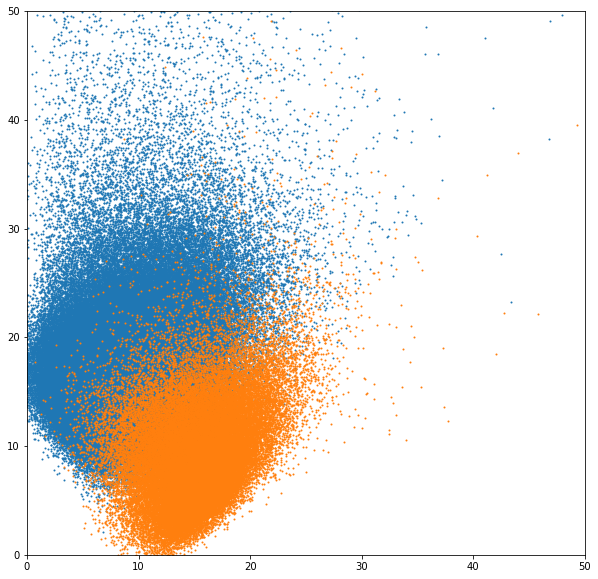

In [24]:
plt.figure(figsize=(10,10))
plt.scatter(bkg_losses_bkg,bkg_losses,s=1)
plt.scatter(sig_losses_bkg,sig_losses,s=1)
plt.xlim([0,50])
plt.ylim([0,50])
plt.savefig("plots/mass_decorrelation/XYY-training/quak-space-noTransform.png")

Text(0.5, 1.0, 'Bkg mass - (sigtr bkg loss < 10) & (bkgtr bkg loss > 10)')

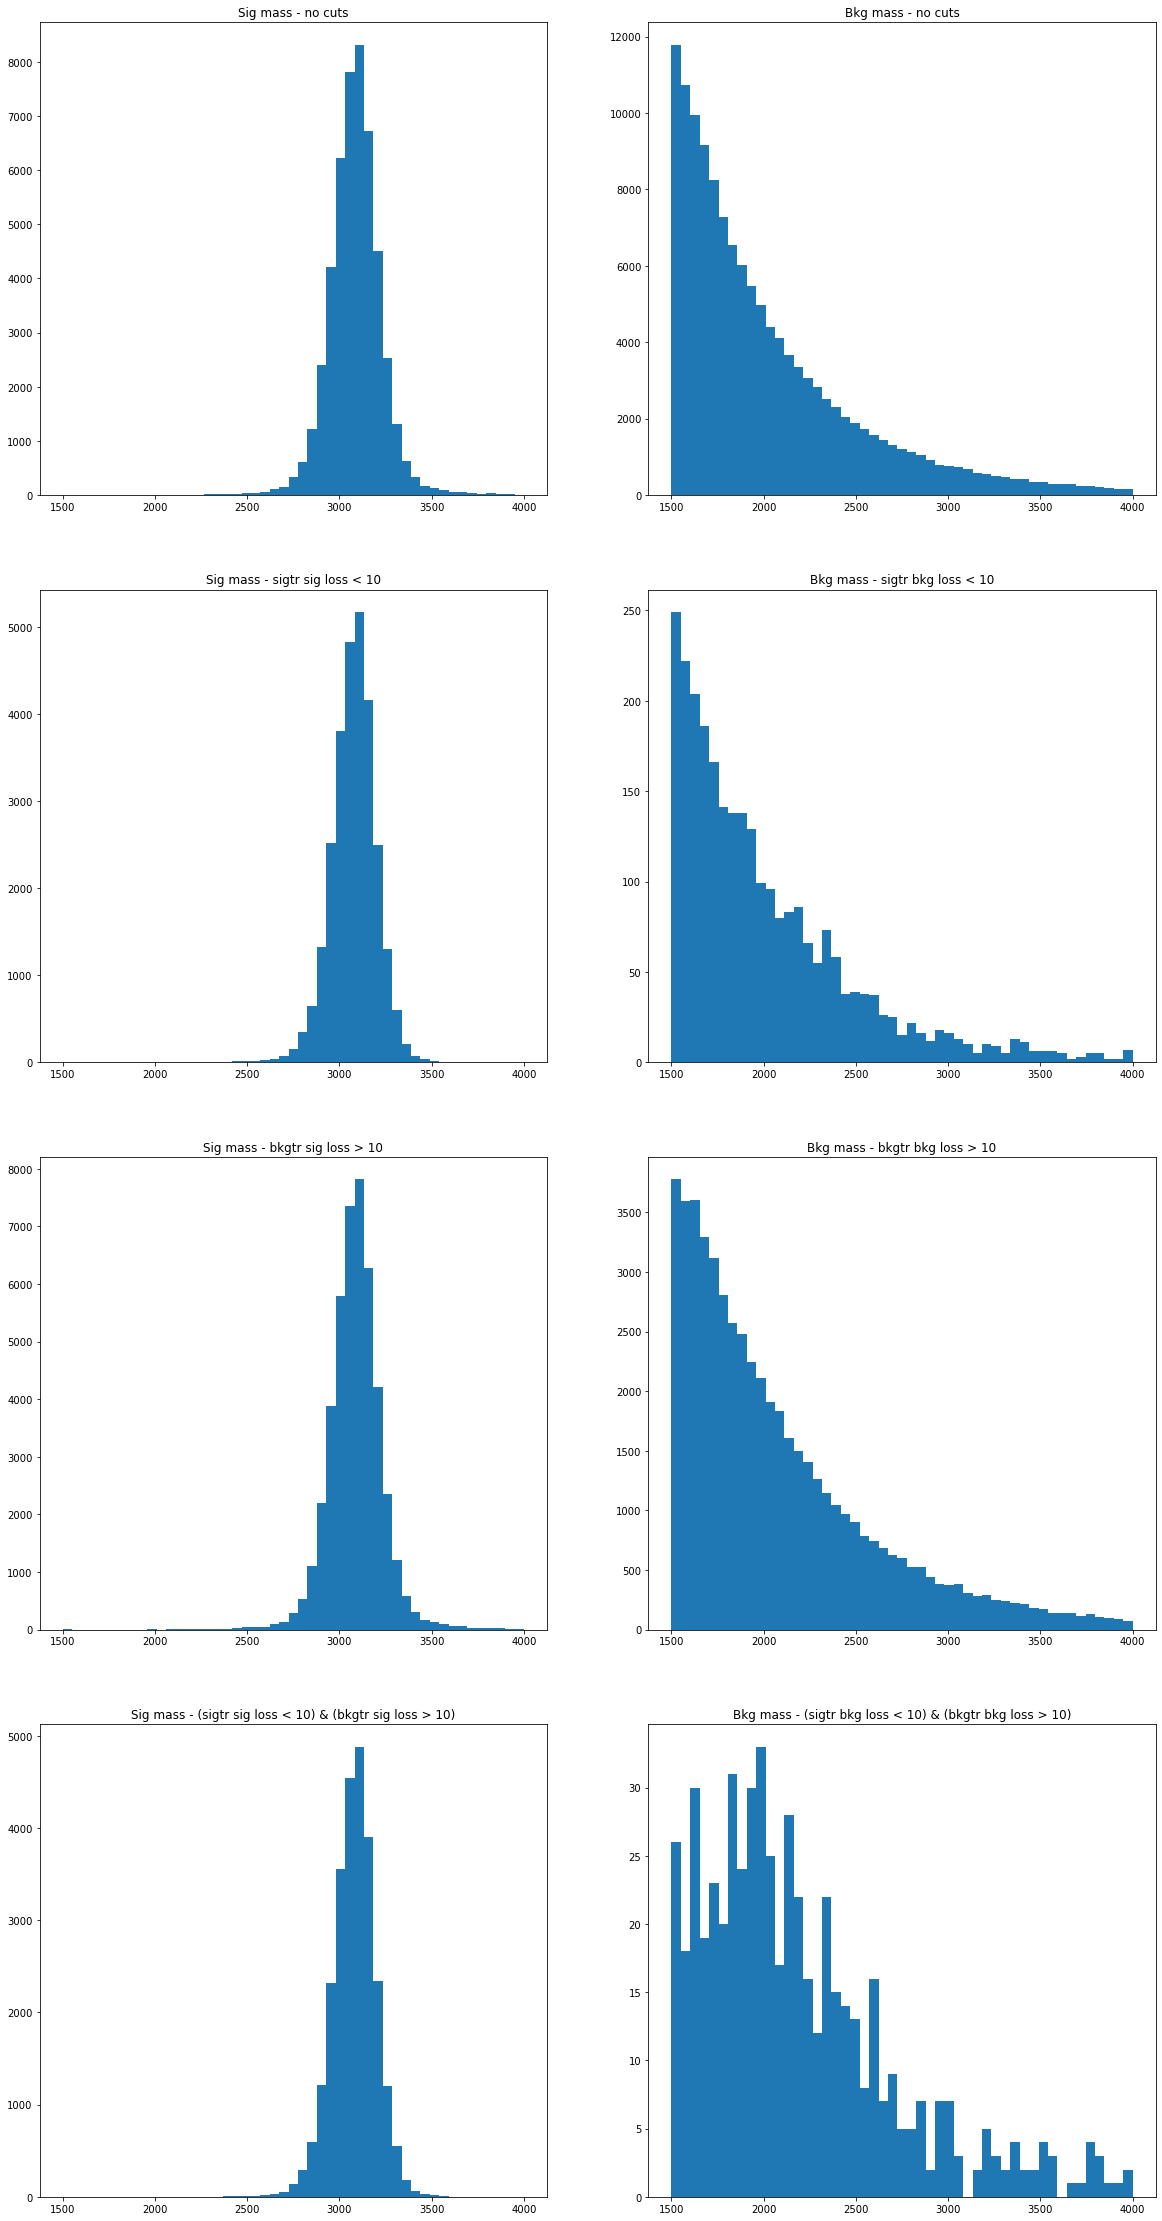

In [26]:
plt.figure(figsize=(20,40))

sig_cut = 10
bkg_cut = 10

plt.subplot(421)
h1 = plt.hist(sig_mass[good_sig],bins=np.linspace(1500,4000,num=50))
plt.title("Sig mass - no cuts")

plt.subplot(422)
h2 = plt.hist(bkg_mass[good_bkg],bins=np.linspace(1500,4000,num=50))
plt.title("Bkg mass - no cuts")

plt.subplot(423)
h1 = plt.hist(sig_mass[good_sig][(sig_losses<sig_cut)],bins=np.linspace(1500,4000,num=50))
plt.title("Sig mass - sigtr sig loss < {}".format(sig_cut))

plt.subplot(424)
h2 = plt.hist(bkg_mass[good_bkg][(bkg_losses<sig_cut)],bins=np.linspace(1500,4000,num=50))
plt.title("Bkg mass - sigtr bkg loss < {}".format(sig_cut))

plt.subplot(425)
h1 = plt.hist(sig_mass[good_sig][(sig_losses_bkg>bkg_cut)],bins=np.linspace(1500,4000,num=50))
plt.title("Sig mass - bkgtr sig loss > {}".format(bkg_cut))

plt.subplot(426)
h2 = plt.hist(bkg_mass[good_bkg][(bkg_losses_bkg>bkg_cut)],bins=np.linspace(1500,4000,num=50))
plt.title("Bkg mass - bkgtr bkg loss > {}".format(bkg_cut))

plt.subplot(427)
h1 = plt.hist(sig_mass[good_sig][(sig_losses<sig_cut)&(sig_losses_bkg>bkg_cut)],bins=np.linspace(1500,4000,num=50))
plt.title("Sig mass - (sigtr sig loss < {}) & (bkgtr sig loss > {})".format(sig_cut,bkg_cut))

plt.subplot(428)
h2 = plt.hist(bkg_mass[good_bkg][(bkg_losses<sig_cut)&(bkg_losses_bkg>bkg_cut)],bins=np.linspace(1500,4000,num=50))
plt.title("Bkg mass - (sigtr bkg loss < {}) & (bkgtr bkg loss > {})".format(sig_cut,bkg_cut))
